###Mounting Drive

In [ ]:
from google.colab import drive

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
train_dir="/content/drive/MyDrive/Capstone/Images/train_small"
test_dir="/content/drive/MyDrive/Capstone/Images/test_small"

###Making dataset

In [ ]:
import os
import random
import shutil

def select_and_copy_files(input_dir, output_dir, percentage=5):
    # Get a list of all files in the input directory
    all_files = os.listdir(input_dir)

    # Calculate the number of files to select based on the given percentage
    num_files_to_select = int(len(all_files) * (percentage / 100))

    # Randomly select files
    selected_files = random.sample(all_files, num_files_to_select)

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Copy selected files to the output directory
    for file_name in selected_files:
        file_path = os.path.join(input_dir, file_name)
        shutil.copy(file_path, output_dir)

In [ ]:
input_dir="/content/drive/MyDrive/Capstone/Images/train/Real/"
output_dir="/content/drive/MyDrive/Capstone/Images/train_small_15/Real/"

select_and_copy_files(input_dir, output_dir, percentage=15)

In [ ]:
input_dir="/content/drive/MyDrive/Capstone/Images/train/Fake/"
output_dir="/content/drive/MyDrive/Capstone/Images/train_small_15/Fake/"

select_and_copy_files(input_dir, output_dir, percentage=15)

In [ ]:
input_dir="/content/drive/MyDrive/Capstone/Images/test/Real/"
output_dir="/content/drive/MyDrive/Capstone/Images/test_small_15/Real/"

select_and_copy_files(input_dir, output_dir, percentage=15)

In [ ]:
input_dir="/content/drive/MyDrive/Capstone/Images/test/Fake/"
output_dir="/content/drive/MyDrive/Capstone/Images/test_small_15/Fake/"

select_and_copy_files(input_dir, output_dir, percentage=15)

In [ ]:
input_dir="/content/drive/MyDrive/Capstone/Images/val/Real/"
output_dir="/content/drive/MyDrive/Capstone/Images/val_small_15/Real/"

select_and_copy_files(input_dir, output_dir, percentage=15)

In [ ]:
input_dir="/content/drive/MyDrive/Capstone/Images/val/Fake/"
output_dir="/content/drive/MyDrive/Capstone/Images/val_small_15/Fake/"

select_and_copy_files(input_dir, output_dir, percentage=15)

###Engine

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
import os
import zipfile
from pathlib import Path
import requests
import os


def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    plt.legend(prop={"size": 14})


def accuracy_fn(y_true, y_pred):

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45

def print_train_time(start, end, device=None):

    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time


# Plot loss curves of a model
def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

from typing import List
import torchvision


def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.0

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [ ]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    i=1

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)


    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [ ]:
!pip install torchinfo

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [ ]:
# prompt: check if TPU cores are avaiable

import torch
print(torch.cuda.is_available())


True


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

###Code

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
class_names = ['Real','Fake']

pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 66.6MB/s]


In [ ]:

from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [ ]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [ ]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)

In [ ]:
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=50,
                                      device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6473 | train_acc: 0.6150 | test_loss: 0.5993 | test_acc: 0.6740
Epoch: 2 | train_loss: 0.5645 | train_acc: 0.7232 | test_loss: 0.5826 | test_acc: 0.7030
Epoch: 3 | train_loss: 0.5234 | train_acc: 0.7502 | test_loss: 0.5488 | test_acc: 0.7340
Epoch: 4 | train_loss: 0.4942 | train_acc: 0.7796 | test_loss: 0.5421 | test_acc: 0.7483
Epoch: 5 | train_loss: 0.4724 | train_acc: 0.7845 | test_loss: 0.5272 | test_acc: 0.7531
Epoch: 6 | train_loss: 0.4504 | train_acc: 0.8003 | test_loss: 0.5024 | test_acc: 0.7699
Epoch: 7 | train_loss: 0.4422 | train_acc: 0.8046 | test_loss: 0.5000 | test_acc: 0.7552
Epoch: 8 | train_loss: 0.4250 | train_acc: 0.8180 | test_loss: 0.4873 | test_acc: 0.7699
Epoch: 9 | train_loss: 0.4108 | train_acc: 0.8265 | test_loss: 0.4820 | test_acc: 0.7627
Epoch: 10 | train_loss: 0.4029 | train_acc: 0.8331 | test_loss: 0.4844 | test_acc: 0.7627
Epoch: 11 | train_loss: 0.3970 | train_acc: 0.8340 | test_loss: 0.4755 | test_acc: 0.7699
Epoch: 12 | train_l

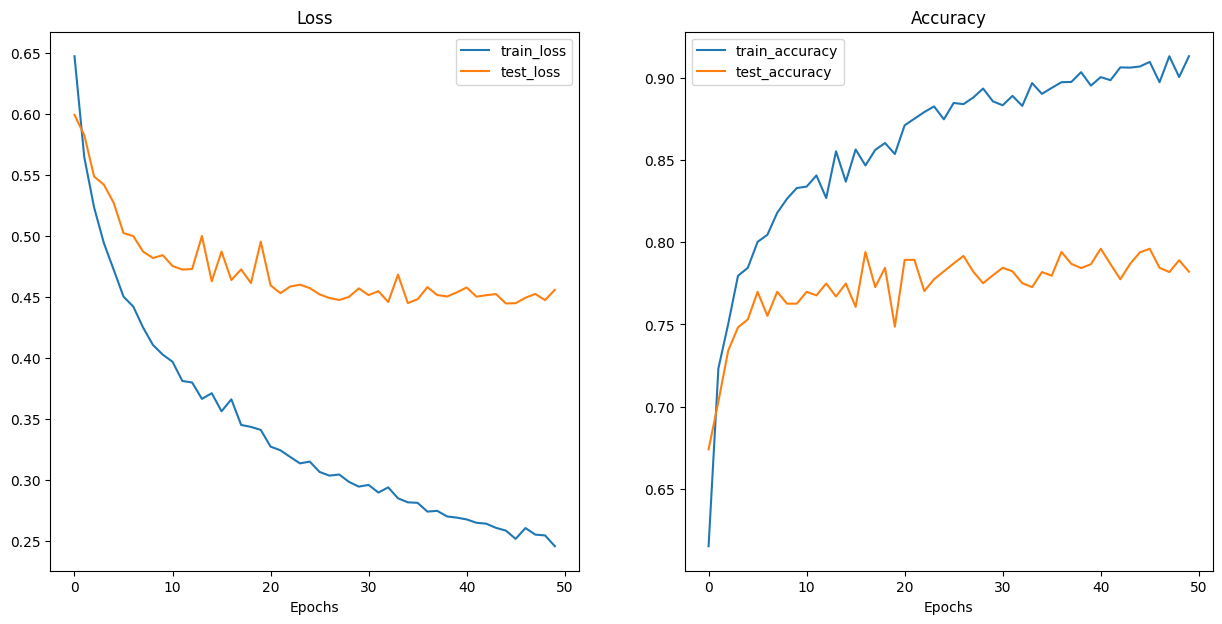

In [ ]:

plot_loss_curves(pretrained_vit_results)

In [ ]:
import requests

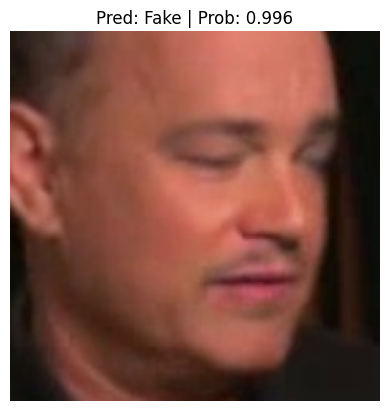

In [ ]:
custom_image_path = "/content/drive/MyDrive/Capstone/Images/val_small/Fake/samples_id20_id19_0006.mp4_face_16_0.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

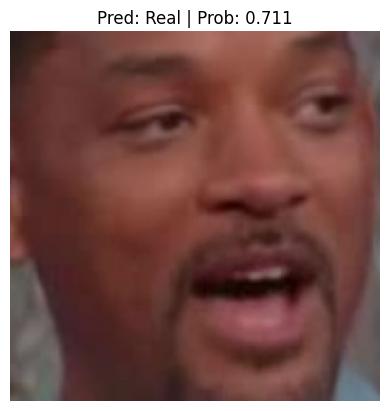

In [ ]:
custom_image_path = "/content/drive/MyDrive/Capstone/Images/val_small/Real/samples_id5_0000.mp4_face_13_0.jpg"
# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

###Different Weights


In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_swag_weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit_swag = torchvision.models.vit_b_16(weights=pretrained_vit_swag_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit_swag.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
class_names = ['Real','Fake']

pretrained_vit_swag.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

In [ ]:
summary(model=pretrained_vit_swag,
        input_size=(32, 3, 384, 384), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 384, 384]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 384, 384]    [32, 768, 24, 24]    (590,592)            False
├─Encoder (encoder)                                          [32, 577, 768]       [32, 577, 768]       443,136              False
│    └─Dropout (dropout)                                     [32, 577, 768]       [32, 577, 768]       --                   --
│    └─Sequential (layers)                                   [32, 577, 768]       [32, 577, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 577, 768]       [32, 577, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 577, 768]       [32, 

In [ ]:
pretrained_vit_swag_transforms = pretrained_vit_swag_weights.transforms()
print(pretrained_vit_swag_transforms)

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [ ]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_swag_transforms,
                                                                                                     batch_size=32)

In [ ]:
optimizer = torch.optim.Adam(params=pretrained_vit_swag.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

pretrained_vit_results = train(model=pretrained_vit_swag,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=50,
                                      device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6432 | train_acc: 0.6235 | test_loss: 0.6180 | test_acc: 0.6761
Epoch: 2 | train_loss: 0.5515 | train_acc: 0.7049 | test_loss: 0.5840 | test_acc: 0.7052
Epoch: 3 | train_loss: 0.4934 | train_acc: 0.7630 | test_loss: 0.5623 | test_acc: 0.6713
Epoch: 4 | train_loss: 0.4618 | train_acc: 0.7874 | test_loss: 0.5214 | test_acc: 0.7290
Epoch: 5 | train_loss: 0.4378 | train_acc: 0.7978 | test_loss: 0.5272 | test_acc: 0.7216
Epoch: 6 | train_loss: 0.4169 | train_acc: 0.8130 | test_loss: 0.4997 | test_acc: 0.7386
Epoch: 7 | train_loss: 0.3953 | train_acc: 0.8303 | test_loss: 0.4906 | test_acc: 0.7533
Epoch: 8 | train_loss: 0.4122 | train_acc: 0.8103 | test_loss: 0.4968 | test_acc: 0.7504
Epoch: 9 | train_loss: 0.3782 | train_acc: 0.8425 | test_loss: 0.4885 | test_acc: 0.7504
Epoch: 10 | train_loss: 0.3610 | train_acc: 0.8593 | test_loss: 0.4864 | test_acc: 0.7605
Epoch: 11 | train_loss: 0.3503 | train_acc: 0.8657 | test_loss: 0.4748 | test_acc: 0.7699
Epoch: 12 | train_l

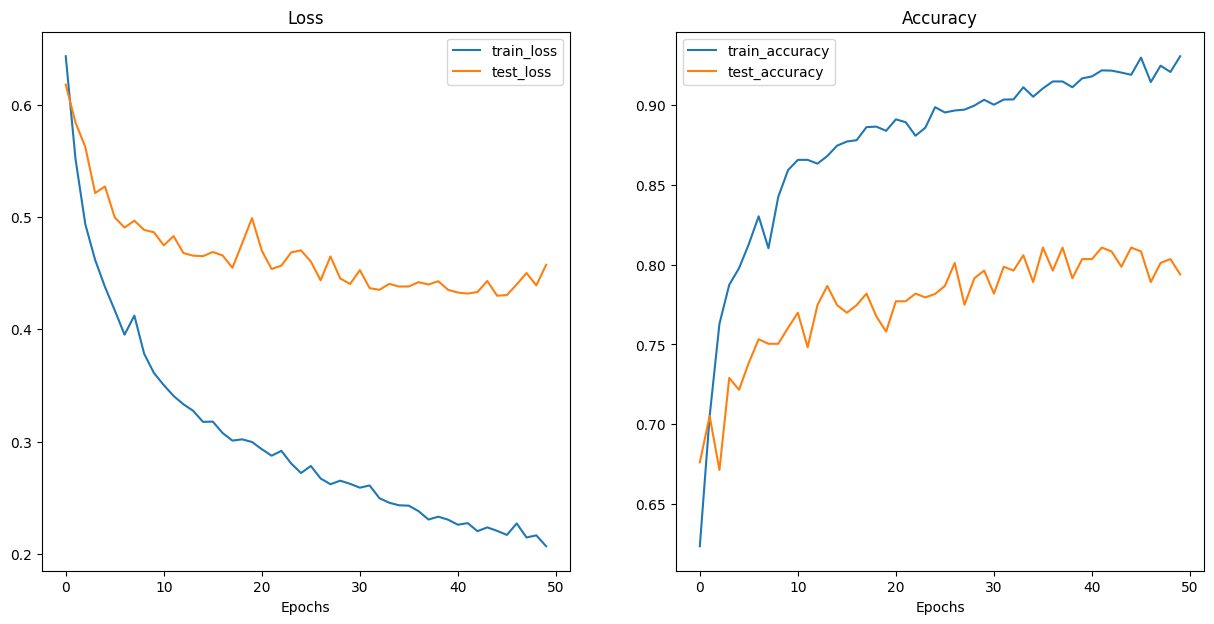

In [ ]:

plot_loss_curves(pretrained_vit_results)

In [ ]:
from PIL import Image

In [ ]:
custom_image_path = "/content/drive/MyDrive/Capstone/Images/val_small/Fake/samples_id20_id19_0006.mp4_face_16_0.jpg"

image = Image.open(custom_image_path)
image = image.resize((384, 384))
# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=image,
                    class_names=class_names)

RuntimeError: [Errno 2] No such file or directory: '<PIL.Image.Image image mode=RGB size=384x384 at 0x7EF9706E7040>'

###Retraining Last Layer

In [ ]:
# 1. Get pretrained weights for ViT-Base
unpretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
unpretrained_vit = torchvision.models.vit_b_16(weights=unpretrained_vit_weights).to(device)

# for name, parameter in pretrained_vit.named_parameters():
#     print(f"name: {name}")

unfreeze_layers=["encoder.layers.encoder_layer_11.mlp.3.bias","encoder.layers.encoder_layer_10.mlp.3.bias","encoder.ln.weight","encoder.ln.bias","heads.head.weight","heads.head.bias"]
# 3. Freeze the base parameters
for parameter in unpretrained_vit.parameters():
    parameter.requires_grad = False

#4 unfreeze the selected layers

for name, parameter in unpretrained_vit.named_parameters():
    if name in unfreeze_layers:
        parameter.requires_grad=True


In [ ]:
class_names = ['Real','Fake']

unpretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

In [ ]:
summary(model=unpretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              Partial
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   Partial
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [

In [ ]:
unpretrained_vit_transforms = unpretrained_vit_weights.transforms()
print(unpretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=unpretrained_vit_transforms,
                                                                                                     batch_size=32)

In [ ]:
optimizer = torch.optim.Adam(params=unpretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

unpretrained_vit_results = train(model=unpretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=100,
                                      device=device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1844 | train_acc: 0.9389 | test_loss: 0.4891 | test_acc: 0.7963
Epoch: 2 | train_loss: 0.1670 | train_acc: 0.9500 | test_loss: 0.4898 | test_acc: 0.8007
Epoch: 3 | train_loss: 0.1794 | train_acc: 0.9371 | test_loss: 0.4858 | test_acc: 0.7889
Epoch: 4 | train_loss: 0.1658 | train_acc: 0.9458 | test_loss: 0.4894 | test_acc: 0.7937
Epoch: 5 | train_loss: 0.1686 | train_acc: 0.9461 | test_loss: 0.4924 | test_acc: 0.8105
Epoch: 6 | train_loss: 0.1631 | train_acc: 0.9472 | test_loss: 0.4950 | test_acc: 0.7957
Epoch: 7 | train_loss: 0.1599 | train_acc: 0.9442 | test_loss: 0.5040 | test_acc: 0.7981
Epoch: 8 | train_loss: 0.1628 | train_acc: 0.9460 | test_loss: 0.4899 | test_acc: 0.8079
Epoch: 9 | train_loss: 0.1613 | train_acc: 0.9514 | test_loss: 0.5489 | test_acc: 0.8009
Epoch: 10 | train_loss: 0.1745 | train_acc: 0.9313 | test_loss: 0.5071 | test_acc: 0.7843
Epoch: 11 | train_loss: 0.1498 | train_acc: 0.9535 | test_loss: 0.5027 | test_acc: 0.7937
Epoch: 12 | train_l

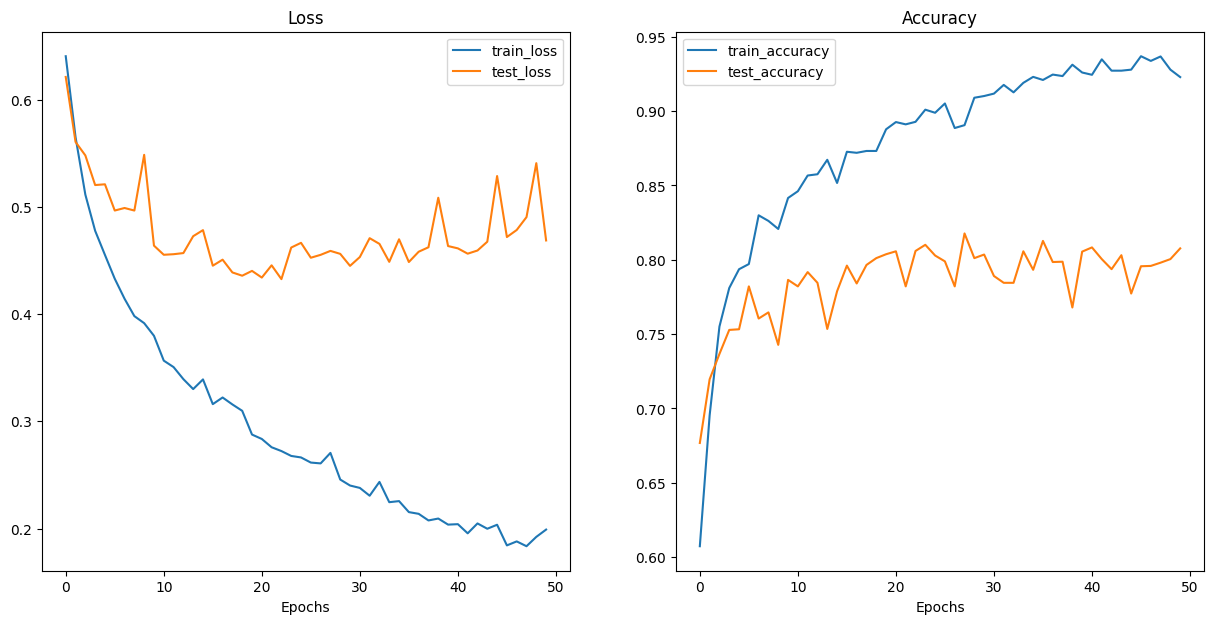

In [ ]:
plot_loss_curves(pretrained_vit_results)